# Kmeans Clustering

Clustering is an unsupervised learning method as we don't have labels for the dataset. We try to find similarity by forming cluster in an n-dimensional space. Points which are "closer" to each other are considered more similar than the ones which are further apart. This "closeness" can be measure in a number of ways like Euclidian distance, cosine similarity etc.

Kmeans is one of the most popular clustering algorithm. Our objective is to find k points in the n-dimensional space such these points sit at the centre of the k dense clusters formed by plotting the dataset in n-dimensional space. The basic implementation of the algorithm is as follows

1) Select k unique random points from the dataset and call them inital centroids

2) For each point in the dataset find the closest centroid and assign that point to the cluster of that centroid

3) For each cluster,calculate the mean of all the points. Mean values will give new centroids

4) Repeat steps 2 and 3 until you get a new set of centroids which is very close to the previous one.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.datasets.samples_generator import make_blobs

In [2]:
def initialize_centroids(X,k):
    """
    randomly picks k unique points from X as the initial centroids
    
    inputs--
    X: input matrix--> np.ndarray
    k: number of centroids
    
    outputs--
    array of centroid vectors
    """ 
    return X[np.random.choice(range(X.shape[0]), k, replace=False)]

In [3]:
def distance_bw_centroids(old:np.ndarray,new:np.ndarray):
    """returns euclidian distance between old and new centroids"""
    return np.linalg.norm(old.ravel()-new.ravel())  

In [4]:
def assign_buckets(X:np.ndarray, centroids:np.ndarray):
    """
    returns a np.array of bucket indices
    for a given set of points and centroids
    """
    dist_matrix = np.stack([np.linalg.norm(X-c, axis=1) for c in centroids])
    return np.argmin(dist_matrix, axis=0)

In [5]:
def kmeans(X:np.ndarray, k:int, centroids=None, tolerance=1e-2):
    """
    Inputs :
        X:Dataset array
        k:number of clusters
        centroids: None for random initialization, 'kmeans++' for smart initialization
        tolerance: max tolerable distance between new and old centroids
    Outputs :
        array of centroids (k,X.shape[1])
        array of cluster indices corresponding to each data-point (X.shape[0])
    """
    if centroids=='kmeans++':
        centroids = initialize_centroids_plus(X,k)
    else:
        centroids = initialize_centroids(X,k)
    
    # for values of k>20, it takes a very long time to converge
    # so we are putting a limit on iterations such that if k increases, number of iterations decrease
    # also we can have more iterations for smaller values of k, which will yield a better set of centroids
    iter_limit = int(800/k)
    iters = 0
    d = 5    
    while (d > tolerance) and (iters< iter_limit):
        bucket_idx = assign_buckets(X, centroids)
        new_centroids = [np.mean(X[bucket_idx == i], keepdims = True, axis = 0 ) for i in range(k)]
        new_centroids = np.array(new_centroids).ravel().reshape(k,X.shape[1])
        old_centroids = centroids
        centroids = new_centroids
        d = distance_bw_centroids(old_centroids, new_centroids)
        iters+=1
    return centroids,bucket_idx

### TOY Dataset with Random Initialization

[]

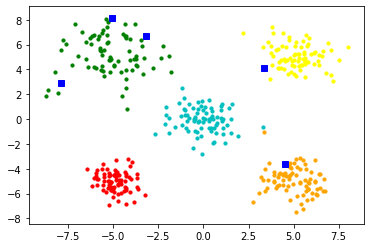

In [17]:
#creating dataset
centers = [(-5, -5), (5, 5), (-5,5),(5,-5), (0,0)]
cluster_std = [0.8, 1, 1.5,1, 1]

X, y = make_blobs(n_samples=400, cluster_std=cluster_std, centers=centers, n_features=4, random_state=1)

#initial centroids
centroids = initialize_centroids(X,5)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="yellow", s=10, label="Cluster2")
plt.scatter(X[y == 2, 0], X[y == 2, 1], color="green", s=10, label="Cluster3")
plt.scatter(X[y == 3, 0], X[y == 3, 1], color="orange", s=10, label="Cluster4")
plt.scatter(X[y == 4, 0], X[y == 4, 1], color="c", s=10, label="Cluster5")
plt.plot(centroids[:,0],centroids[:,1],"bs")
plt.plot()

### After applying kmeans with Random Initialization

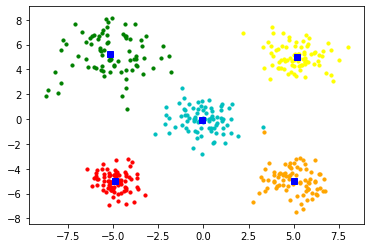

In [18]:
center_kmeans, buckets_kmeans  = kmeans(X,k=5)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="yellow", s=10, label="Cluster2")
plt.scatter(X[y == 2, 0], X[y == 2, 1], color="green", s=10, label="Cluster3")
plt.scatter(X[y == 3, 0], X[y == 3, 1], color="orange", s=10, label="Cluster4")
plt.scatter(X[y == 4, 0], X[y == 4, 1], color="c", s=10, label="Cluster5")
plt.plot(center_kmeans[:,0],center_kmeans[:,1],"bs")

## KMEANS++

As you can see when we randomly initialize, points chosen as initial centroids are far from optimal solution. For larger datasets this may result in slower convergence towards the optimal centroids. As a solution to this problem we use "kmeans++"

How does Kmeans++ initialize centroids?

1) Pick a random point from the dataset as the first centroid.

2) Find a point in the dataset which is farthest from this point and make it the second centroid.

3) Now for selecting the third centroid, for each point in the dataset find the minimum distance of that point from the current set of centroids and then select the point for which this "minimum" distance is the maximum(example below)

4) repeat step 3 till we obtain k centroids



Example:
Our dataset has 10 points p1,....,p10
we already selected two centroids, c1(lets say p3) and c2(lets say p7) using the above steps
Next we are trying to find the third centroid

MAX (
    min(p1-c1, p1-c2),
    min(p2-c1, p2-c2),
    min(p3-c1, p3-c2),
    min(p4-c1, p4-c2),
    min(p5-c1, p5-c2),
    min(p6-c1, p6-c2),
    min(p7-c1, p7-c2),
    min(p8-c1, p8-c2),
    min(p9-c1, p9-c2),
    min(p10-c1, p10-c2) 
    )
    
Lets assume we get p4-c2 after this operation, then p4 becomes our third centroid

In [8]:
def initialize_centroids_plus(X:np.ndarray,k:int):
    """
    implementing kmeans++ initialization
    input : X,k
    output : returns k smartly selected centroids
    """
    centroids = initialize_centroids(X,1)
    for _ in range(k-1):
        dist_matrix = np.stack([np.linalg.norm(X-c, axis=1) for c in centroids]) #centroids*X.shape[0]
        min_point_to_centroids = np.min(dist_matrix, axis=0)
        new_centroid_idx = np.argmax(min_point_to_centroids)
        centroids = np.vstack((centroids,X[new_centroid_idx]))
    return centroids

### TOY dataset the kmeans++ initialization

[]

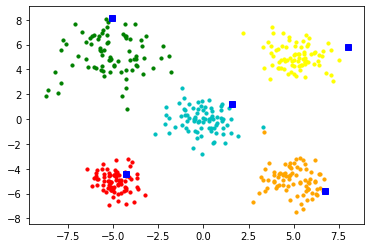

In [9]:
centroids = initialize_centroids_plus(X,5)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color="red", s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="yellow", s=10, label="Cluster2")
plt.scatter(X[y == 2, 0], X[y == 2, 1], color="green", s=10, label="Cluster3")
plt.scatter(X[y == 3, 0], X[y == 3, 1], color="orange", s=10, label="Cluster4")
plt.scatter(X[y == 4, 0], X[y == 4, 1], color="c", s=10, label="Cluster5")
plt.plot(centroids[:,0],centroids[:,1],"bs")
plt.plot()

## MODEL EVALUATION

### Elbow Plot

Elbow plot helps us estimte the value of k which will best for the data at hand. We choose the value of k for which either sse is smallest or after which the plot begins to flatten. The intuition is, we want the k for which the error is smallest(lowest point in the graph) or we could go for k beyond which plot begins to flatten, meaning even if we increase the clusters beyond that point, error is not going to decrease. As discussed above, if we go for more clusters this algorithm start to get more expesive.

In [10]:
def sse(X, k):
    center_kmeans, buckets_kmeans  = kmeans(X,k,centroids='kmeans++')
    sum_err = 0
    for i in range(k):
        sum_err += np.linalg.norm(X[buckets_kmeans==i]-center_kmeans[i])
    return sum_err    

Text(0.5, 1.0, 'Elbow Plot')

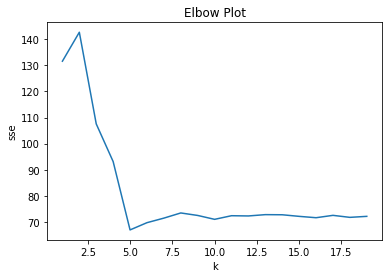

In [11]:
x_axis, y_axis = [],[]
for k in range(1,20):
    x_axis.append(k)
    y_axis.append(sse(X,k))

plt.plot(x_axis, y_axis)
plt.xlabel("k")
plt.ylabel("sse")
plt.title("Elbow Plot")
    

We choose k = 5 in this case

## IMAGE COMPRESSION

One of the interesting applications of clustering is image compression. We take an image which has all sorts of colors and compress to an image with only a few. How do we go about this?

(Please refer to the ipynb in case pdf is not clear)
Intuition:
1) We split the image into three channels (r,g and b)
2) For the below 4X3 coloured image, each pixel has r,g and b intensity values.
   12 44 12 12   11 14 22 18   23 56 89 91
   22 32 01 02   12 72 92 31   81 92 74 65
   42 31 15 29   14 23 46 69   22 33 44 81
3) Next we represent each pixel as a vector (r,g,b)
   In this case P11 -> (12,11,23) 
                P32 -> (31,23,33) and so on
4) Here we will end up with (3*4, 3) matrix.
5) Kmeans clustering on this dataset will give us a set of centroids. Color associated with each centroid will be the color by which the respective cluster will be identified.

In [12]:
def compressor(pic:np.ndarray,k:int):
    """
    inputs : 
        pic : original image matrix of the form (h,w,c)
        k   : number of clusters
    output : compressed image
    """
    if len(pic.shape)==2: #greyscale images
        h,w = pic.shape
        c =1
    else:
        h,w,c = pic.shape
    pic = pic.reshape(h*w,c)
    centroids, buckets_idx = kmeans(pic,k=k, centroids='kmeans++')
    new_img_arr = centroids[buckets_idx].astype('uint8')
    if c==1:
        new_img_matrix = new_img_arr.reshape(h,w)
    else:
        new_img_matrix = new_img_arr.reshape(h,w,c)
    return Image.fromarray(new_img_matrix)

number of unique colours in this picture is 256


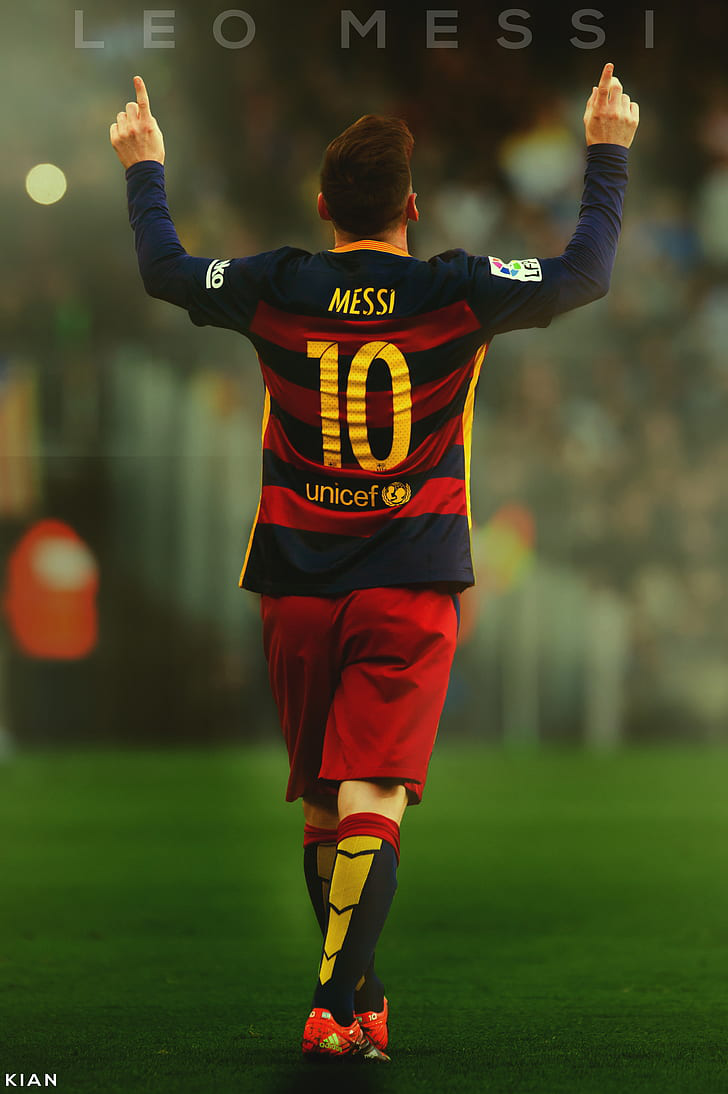

In [13]:
#image import
im = Image.open('messi.jpg')
pic_array = np.asarray(im)
h,w,c = pic_array.shape
uniq_colors = len(np.unique(pic_array.reshape(h*w,c)))
print(f"number of unique colours in this picture is {uniq_colors}")
im

number of unique colours in this picture is 48


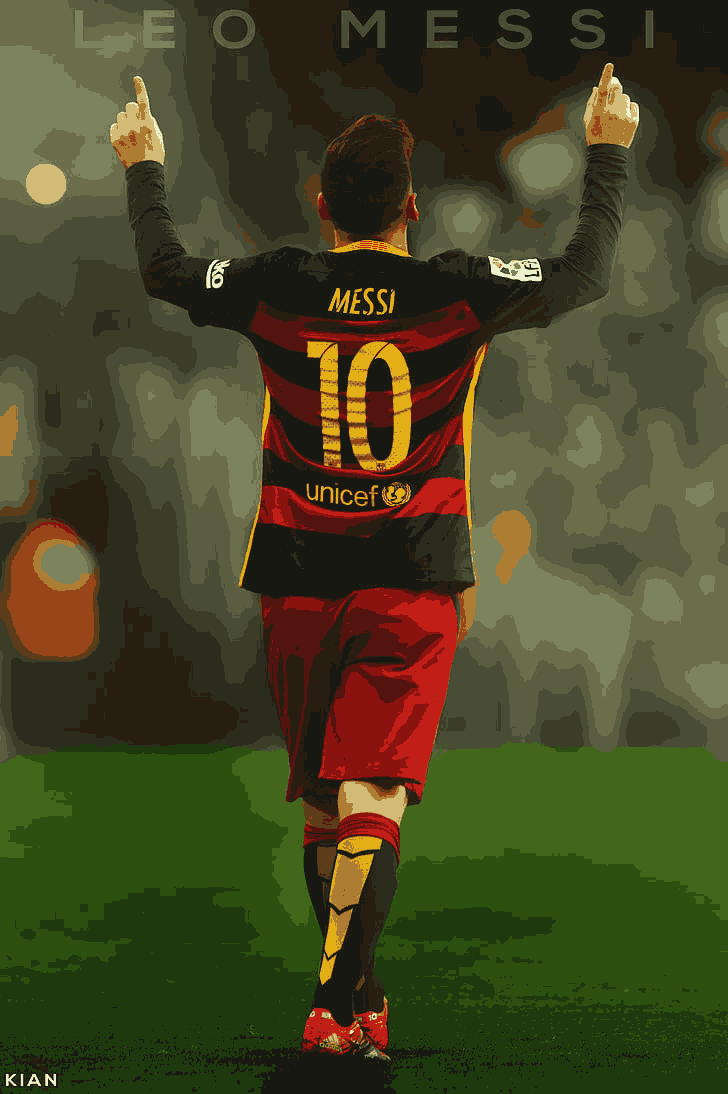

In [14]:
#compressed image
compressed_pic = compressor(pic_array,20)
pic_array = np.asarray(compressed_pic)
h,w,c = pic_array.shape
uniq_colors = len(np.unique(pic_array.reshape(h*w,c)))
print(f"number of unique colours in this picture is {uniq_colors}")
compressed_pic

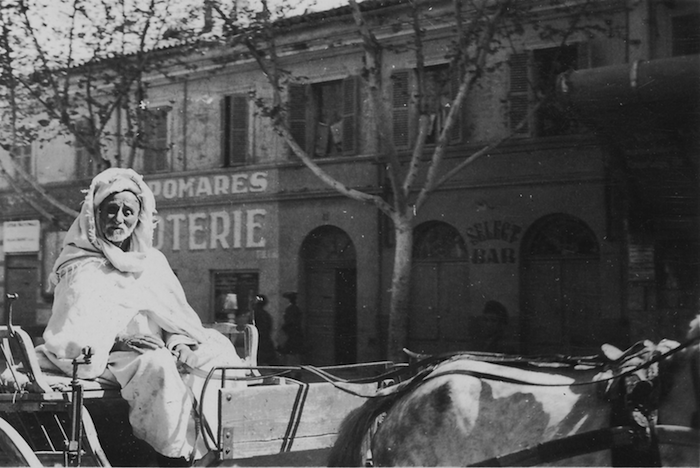

In [15]:
#grey scale images
im = Image.open('north-africa-1940s-grey.png')
pic_array = np.asarray(im)
im

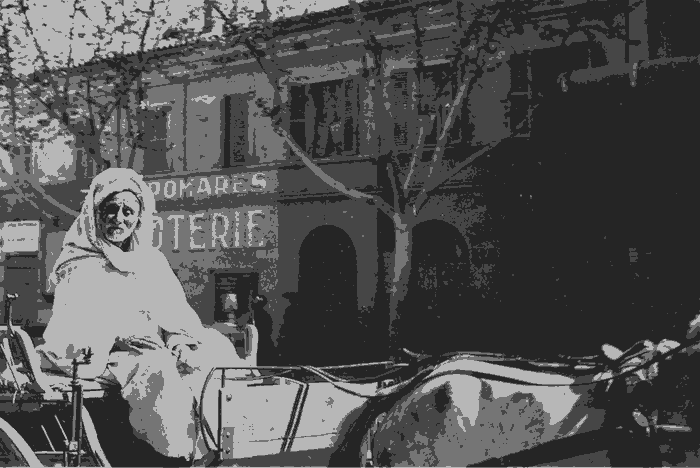

In [16]:
compressed_pic = compressor(pic_array,4)
compressed_pic